In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

data = pd.read_excel('Level5_Rumen_with_metadata.xlsx')

In [3]:
data = data.drop(columns=['sample_ID'])

###jC

print(data.isnull().sum().sum()) 


0


In [4]:
#separatingg cat and con
continuous_features = data.drop(columns=['RFI', 'DNA_Batch', 'Farm_Code'])
categorical_features = data[['DNA_Batch', 'Farm_Code']]

# Log trans

In [5]:
# i dont need to log transform targ
continuous_features = continuous_features.applymap(lambda x: np.log1p(x))

#Jc
print("\nTransformed features summary:")
print(continuous_features.describe())


Transformed features summary:
          172606-1         70-9  Abditibacteriaceae  Acetivibrionaceae  \
count  1176.000000  1176.000000         1176.000000        1176.000000   
mean      0.000008     0.000024            0.000010           0.000022   
std       0.000274     0.000420            0.000359           0.000598   
min       0.000000     0.000000            0.000000           0.000000   
25%       0.000000     0.000000            0.000000           0.000000   
50%       0.000000     0.000000            0.000000           0.000000   
75%       0.000000     0.000000            0.000000           0.000000   
max       0.009403     0.010058            0.012313           0.019240   

       Acetobacteraceae  Acetonemaceae  Acholeplasmataceae  \
count       1176.000000    1176.000000         1176.000000   
mean           0.024885       0.000004            0.001511   
std            0.057406       0.000154            0.005242   
min            0.000000       0.000000            0.00

In [6]:
#cat col one hot 
categorical_features = pd.get_dummies(categorical_features, drop_first=True)

#combining both feats cata nd con
features = pd.concat([continuous_features, categorical_features], axis=1)

# standard before PCA

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

#xtr ther y too into the df
y = data['RFI']

# les do PCA .95

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  
X_reduced = pca.fit_transform(X_scaled)

#Jc the colum
print(f"Reduced feature shape: {X_reduced.shape}")  

Reduced feature shape: (1176, 324)


# RF fit and predict 

In [9]:
#80 train split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=1)


rf = RandomForestRegressor(n_estimators=100, random_state=1, n_jobs=-1)

#model
print("\nTraining the Random Forest Regressor...")
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)

# acc check
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nRandom Forest Regression -- R^2 Score: {r2:.4f}, RMSE: {rmse:.4f}")



Training the Random Forest Regressor...

Random Forest Regression -- R^2 Score: 0.3144, RMSE: 2.5661


# now tuning with RSearch

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

#parameter arrrar
param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap': [True, False],
}

#rsear
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=500,
    cv=5,
    n_jobs=-1,
    scoring='r2',
    verbose=2,
    random_state=1,
    return_train_score=True  # Ensure train scores are saved
)


#lets start with 50
print("\nlessssss startttttt searchinggg :D")
random_search.fit(X_train, y_train)

# best 
best_rf = random_search.best_estimator_

# Evaluate the model
y_pred_best = best_rf.predict(X_test)
r2_best = r2_score(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))

print(f"\nOptimized Random Forest Regression -- R^2 Score: {r2_best:.4f}, RMSE: {rmse_best:.4f}")



lessssss startttttt searchinggg :D
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END bootstrap=False, max_depth=47, max_features=auto, min_samples_leaf=15, min_samples_split=6, n_estimators=315; total time=   0.0s
[CV] END bootstrap=False, max_depth=12, max_features=None, min_samples_leaf=11, min_samples_split=16, n_estimators=828; total time=  46.2s
[CV] END bootstrap=True, max_depth=19, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=565; total time=   8.0s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=12, min_samples_split=3, n_estimators=438; total time=  20.4s
[CV] END bootstrap=False, max_depth=47, max_features=log2, min_samples_leaf=15, min_samples_split=19, n_estimators=812; total time=  10.1s
[CV] END bootstrap=False, max_depth=12, max_features=log2, min_samples_leaf=6, min_samples_split=11, n_estimators=434; total time=   9.5s
[CV] END bootstrap=True, max_depth=43, max_features=None, min_samples_lea

[CV] END bootstrap=False, max_depth=45, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=226; total time=   5.9s
[CV] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=17, min_samples_split=2, n_estimators=369; total time=  14.2s
[CV] END bootstrap=False, max_depth=14, max_features=log2, min_samples_leaf=8, min_samples_split=7, n_estimators=520; total time=  13.4s
[CV] END bootstrap=True, max_depth=27, max_features=log2, min_samples_leaf=10, min_samples_split=12, n_estimators=817; total time=   5.9s
[CV] END bootstrap=False, max_depth=39, max_features=sqrt, min_samples_leaf=12, min_samples_split=7, n_estimators=685; total time=  18.2s
[CV] END bootstrap=False, max_depth=19, max_features=auto, min_samples_leaf=9, min_samples_split=10, n_estimators=258; total time=   0.0s
[CV] END bootstrap=False, max_depth=19, max_features=auto, min_samples_leaf=9, min_samples_split=10, n_estimators=258; total time=   0.0s
[CV] END bootstrap=False, max_depth=

/apps/eb/Anaconda3/2023.09-0/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
620 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
346 fits failed with the following error:
Traceback (most recent call last):
  File "/apps/eb/Anaconda3/2023.09-0/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/apps/eb/Anaconda3/2023.09-0/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/apps/eb/Anaconda3/2023.09-0/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_


Optimized Random Forest Regression -- R^2 Score: 0.3370, RMSE: 2.5235


In [11]:
#sav excel for all combination

results_df = pd.DataFrame(random_search.cv_results_)

#making sure rmse is included 
results_df['rmse_test_score'] = np.sqrt(1 - results_df['mean_test_score'])

#cols 
results_df = results_df[['params', 'mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score', 'rmse_test_score']]

###excel
results_df.to_excel("rumen_with_metadata_logtransformatiuon_stand_PCA_optimization.xlsx", index=False)
print("okey dokey saved")



okey dokey saved


In [14]:
print(f"\nOptimized Random Forest Regression -- R^2 Score: {r2_best:.4f}, RMSE: {rmse_best:.4f}")


Optimized Random Forest Regression -- R^2 Score: 0.3370, RMSE: 2.5235


# Features imp

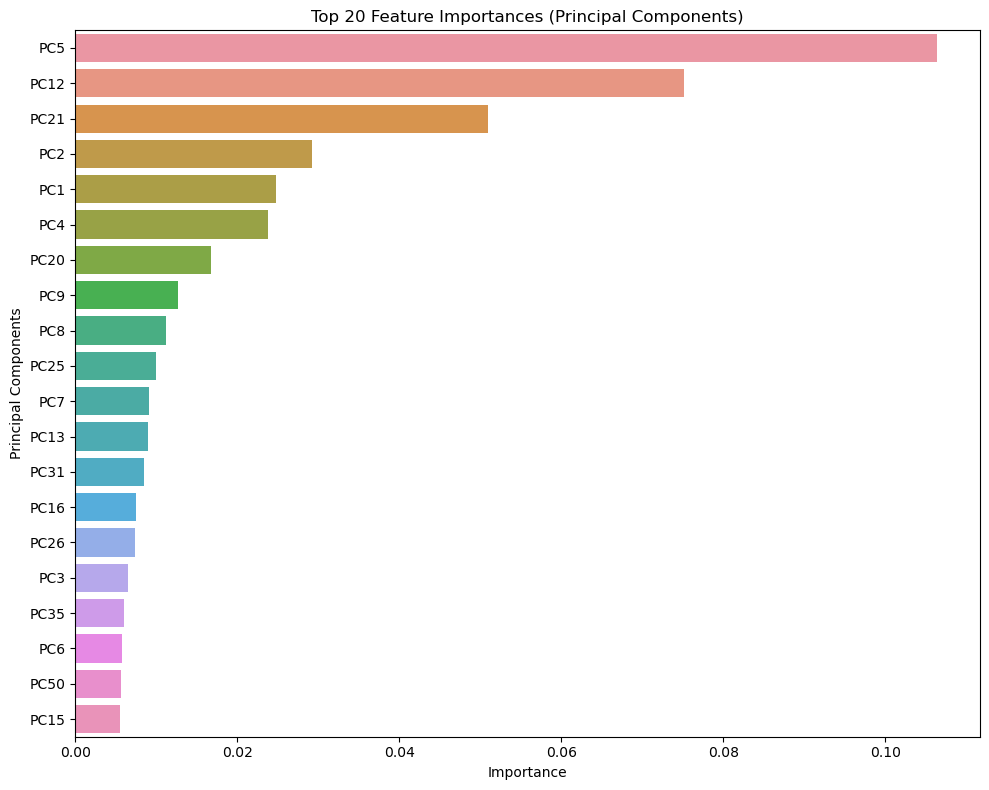

[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=17, min_samples_split=18, n_estimators=645; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=17, min_samples_split=3, n_estimators=683; total time=   0.0s
[CV] END bootstrap=True, max_depth=39, max_features=log2, min_samples_leaf=16, min_samples_split=17, n_estimators=187; total time=   5.6s
[CV] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=9, n_estimators=875; total time=  57.3s
[CV] END bootstrap=True, max_depth=28, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=722; total time=  38.3s
[CV] END bootstrap=False, max_depth=34, max_features=sqrt, min_samples_leaf=12, min_samples_split=17, n_estimators=299; total time=  10.3s
[CV] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=19, min_samples_split=9, n_estimators=832; total time=  15.4s
[CV] END bootstrap=True, max_depth=24,

[CV] END bootstrap=True, max_depth=21, max_features=sqrt, min_samples_leaf=10, min_samples_split=17, n_estimators=164; total time=   6.0s
[CV] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=17, min_samples_split=2, n_estimators=369; total time=  15.7s
[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=14, min_samples_split=5, n_estimators=984; total time=  16.9s
[CV] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=18, n_estimators=375; total time=   6.9s
[CV] END bootstrap=True, max_depth=47, max_features=None, min_samples_leaf=10, min_samples_split=11, n_estimators=541; total time=  25.4s
[CV] END bootstrap=False, max_depth=43, max_features=None, min_samples_leaf=9, min_samples_split=10, n_estimators=297; total time=  25.4s
[CV] END bootstrap=False, max_depth=44, max_features=log2, min_samples_leaf=9, min_samples_split=14, n_estimators=373; total time=   5.5s
[CV] END bootstrap=False, max_depth=3

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=17, min_samples_split=3, n_estimators=683; total time=   0.0s
[CV] END bootstrap=False, max_depth=12, max_features=None, min_samples_leaf=11, min_samples_split=16, n_estimators=828; total time=  45.2s
[CV] END bootstrap=True, max_depth=19, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=565; total time=   8.5s
[CV] END bootstrap=False, max_depth=35, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=250; total time=   0.0s
[CV] END bootstrap=False, max_depth=35, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=250; total time=   0.0s
[CV] END bootstrap=False, max_depth=35, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=250; total time=   0.0s
[CV] END bootstrap=False, max_depth=35, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=250; total time=   0.0s
[CV] END bootstrap=False, max_depth=35,

[CV] END bootstrap=False, max_depth=48, max_features=auto, min_samples_leaf=9, min_samples_split=11, n_estimators=815; total time=   0.0s
[CV] END bootstrap=True, max_depth=18, max_features=log2, min_samples_leaf=7, min_samples_split=4, n_estimators=688; total time=  11.3s
[CV] END bootstrap=True, max_depth=27, max_features=sqrt, min_samples_leaf=14, min_samples_split=19, n_estimators=726; total time=  16.8s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=9, min_samples_split=15, n_estimators=662; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=9, min_samples_split=15, n_estimators=662; total time=   0.0s
[CV] END bootstrap=False, max_depth=46, max_features=auto, min_samples_leaf=13, min_samples_split=19, n_estimators=888; total time=   0.0s
[CV] END bootstrap=False, max_depth=46, max_features=auto, min_samples_leaf=13, min_samples_split=19, n_estimators=888; total time=   0.0s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=46, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=493; total time=   6.2s
[CV] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=17, min_samples_split=2, n_estimators=369; total time=  15.3s
[CV] END bootstrap=True, max_depth=19, max_features=log2, min_samples_leaf=1, min_samples_split=13, n_estimators=647; total time=  15.7s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=17, min_samples_split=18, n_estimators=790; total time=   8.8s
[CV] END bootstrap=True, max_depth=47, max_features=None, min_samples_leaf=10, min_samples_split=11, n_estimators=541; total time=  25.4s
[CV] END bootstrap=True, max_depth=43, max_features=log2, min_samples_leaf=17, min_samples_split=19, n_estimators=610; total time=  12.2s
[CV] END bootstrap=False, max_depth=46, max_features=log2, min_samples_leaf=13, min_samples_split=15, n_estimators=122; total time=   9.0s
[CV] END bootstrap=False, max_depth

[CV] END bootstrap=False, max_depth=27, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=416; total time=   9.4s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=18, min_samples_split=12, n_estimators=120; total time=  12.3s
[CV] END bootstrap=False, max_depth=18, max_features=auto, min_samples_leaf=15, min_samples_split=15, n_estimators=955; total time=   0.0s
[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=14, min_samples_split=5, n_estimators=984; total time=  17.0s
[CV] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=18, n_estimators=375; total time=   5.9s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=12, min_samples_split=3, n_estimators=438; total time=  20.1s
[CV] END bootstrap=True, max_depth=32, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=798; total time=  12.8s
[CV] END bootstrap=True, max_depth=33,

[CV] END bootstrap=True, max_depth=35, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=661; total time=  30.7s
[CV] END bootstrap=True, max_depth=33, max_features=None, min_samples_leaf=19, min_samples_split=12, n_estimators=236; total time=  15.1s
[CV] END bootstrap=True, max_depth=21, max_features=log2, min_samples_leaf=16, min_samples_split=9, n_estimators=608; total time=   9.2s
[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=5, min_samples_split=15, n_estimators=402; total time=  13.4s
[CV] END bootstrap=True, max_depth=24, max_features=auto, min_samples_leaf=14, min_samples_split=18, n_estimators=360; total time=   0.0s
[CV] END bootstrap=True, max_depth=24, max_features=auto, min_samples_leaf=14, min_samples_split=18, n_estimators=360; total time=   0.0s
[CV] END bootstrap=True, max_depth=24, max_features=auto, min_samples_leaf=14, min_samples_split=18, n_estimators=360; total time=   0.0s
[CV] END bootstrap=True, max_depth=24,

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=17, min_samples_split=3, n_estimators=683; total time=   0.0s
[CV] END bootstrap=False, max_depth=26, max_features=None, min_samples_leaf=8, min_samples_split=15, n_estimators=812; total time=  50.1s
[CV] END bootstrap=True, max_depth=18, max_features=None, min_samples_leaf=19, min_samples_split=16, n_estimators=656; total time=  24.8s
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, min_samples_leaf=17, min_samples_split=9, n_estimators=769; total time=  10.6s
[CV] END bootstrap=False, max_depth=12, max_features=log2, min_samples_leaf=6, min_samples_split=11, n_estimators=434; total time=   9.2s
[CV] END bootstrap=True, max_depth=43, max_features=None, min_samples_leaf=1, min_samples_split=7, n_estimators=575; total time=  31.6s
[CV] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=14, min_samples_split=8, n_estimators=471; total time=   9.6s
[CV] END bootstrap=False, max_depth=38

[CV] END bootstrap=False, max_depth=35, max_features=sqrt, min_samples_leaf=17, min_samples_split=14, n_estimators=578; total time=  16.9s
[CV] END bootstrap=False, max_depth=41, max_features=None, min_samples_leaf=6, min_samples_split=8, n_estimators=748; total time=  50.8s
[CV] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=15, min_samples_split=5, n_estimators=540; total time=   7.0s
[CV] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, n_estimators=734; total time=  15.7s
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, min_samples_leaf=17, min_samples_split=9, n_estimators=769; total time=  16.5s
[CV] END bootstrap=True, max_depth=33, max_features=sqrt, min_samples_leaf=1, min_samples_split=7, n_estimators=502; total time=  13.9s
[CV] END bootstrap=False, max_depth=34, max_features=sqrt, min_samples_leaf=12, min_samples_split=17, n_estimators=299; total time=   8.6s
[CV] END bootstrap=False, max_depth=30

[CV] END bootstrap=False, max_depth=46, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=493; total time=  10.3s
[CV] END bootstrap=True, max_depth=27, max_features=sqrt, min_samples_leaf=14, min_samples_split=19, n_estimators=726; total time=  16.2s
[CV] END bootstrap=True, max_depth=33, max_features=None, min_samples_leaf=19, min_samples_split=12, n_estimators=236; total time=  13.9s
[CV] END bootstrap=True, max_depth=18, max_features=None, min_samples_leaf=19, min_samples_split=16, n_estimators=656; total time=  24.8s
[CV] END bootstrap=False, max_depth=38, max_features=log2, min_samples_leaf=10, min_samples_split=13, n_estimators=949; total time=  16.0s
[CV] END bootstrap=False, max_depth=34, max_features=log2, min_samples_leaf=5, min_samples_split=9, n_estimators=896; total time=  14.8s
[CV] END bootstrap=False, max_depth=44, max_features=log2, min_samples_leaf=9, min_samples_split=14, n_estimators=373; total time=   7.5s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=18, min_samples_split=13, n_estimators=688; total time=   0.0s
[CV] END bootstrap=True, max_depth=18, max_features=log2, min_samples_leaf=7, min_samples_split=4, n_estimators=688; total time=  11.6s
[CV] END bootstrap=True, max_depth=27, max_features=sqrt, min_samples_leaf=14, min_samples_split=19, n_estimators=726; total time=  15.9s
[CV] END bootstrap=False, max_depth=34, max_features=sqrt, min_samples_leaf=3, min_samples_split=18, n_estimators=922; total time=  20.1s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=12, min_samples_split=3, n_estimators=438; total time=  20.7s
[CV] END bootstrap=False, max_depth=41, max_features=log2, min_samples_leaf=11, min_samples_split=14, n_estimators=258; total time=  12.6s
[CV] END bootstrap=True, max_depth=33, max_features=sqrt, min_samples_leaf=1, min_samples_split=7, n_estimators=502; total time=  12.4s
[CV] END bootstrap=True, max_depth=27,

[CV] END bootstrap=True, max_depth=21, max_features=sqrt, min_samples_leaf=10, min_samples_split=17, n_estimators=164; total time=   5.4s
[CV] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=9, n_estimators=875; total time=  54.2s
[CV] END bootstrap=False, max_depth=7, max_features=log2, min_samples_leaf=15, min_samples_split=13, n_estimators=542; total time=  14.1s
[CV] END bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=5, min_samples_split=9, n_estimators=224; total time=  11.7s
[CV] END bootstrap=True, max_depth=44, max_features=log2, min_samples_leaf=11, min_samples_split=2, n_estimators=914; total time=  14.5s
[CV] END bootstrap=False, max_depth=39, max_features=log2, min_samples_leaf=14, min_samples_split=12, n_estimators=762; total time=  12.2s
[CV] END bootstrap=False, max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=942; total time= 1.1min
[CV] END bootstrap=False, max_depth=1

[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=9, n_estimators=382; total time=  20.2s
[CV] END bootstrap=True, max_depth=48, max_features=log2, min_samples_leaf=14, min_samples_split=17, n_estimators=636; total time=  10.6s
[CV] END bootstrap=False, max_depth=39, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=551; total time=   0.0s
[CV] END bootstrap=False, max_depth=39, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=551; total time=   0.0s
[CV] END bootstrap=False, max_depth=39, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=551; total time=   0.0s
[CV] END bootstrap=False, max_depth=39, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=551; total time=   0.0s
[CV] END bootstrap=False, max_depth=39, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=551; total time=   0.0s
[CV] END bootstrap=True, max_depth=24, ma

[CV] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=14, min_samples_split=17, n_estimators=733; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=14, min_samples_split=5, n_estimators=996; total time=  15.2s
[CV] END bootstrap=False, max_depth=24, max_features=sqrt, min_samples_leaf=18, min_samples_split=16, n_estimators=241; total time=  11.6s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=15, min_samples_split=13, n_estimators=186; total time=  11.0s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=17, min_samples_split=18, n_estimators=790; total time=   8.1s
[CV] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, n_estimators=734; total time=  15.6s
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, min_samples_leaf=17, min_samples_split=9, n_estimators=769; total time=  15.8s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=False, max_depth=47, max_features=auto, min_samples_leaf=15, min_samples_split=6, n_estimators=315; total time=   0.0s
[CV] END bootstrap=True, max_depth=39, max_features=log2, min_samples_leaf=16, min_samples_split=17, n_estimators=187; total time=   3.6s
[CV] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=9, n_estimators=875; total time=  54.8s
[CV] END bootstrap=False, max_depth=45, max_features=sqrt, min_samples_leaf=8, min_samples_split=18, n_estimators=611; total time=  14.7s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=13, n_estimators=848; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=13, n_estimators=848; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=13, n_estimators=848; total time=   0.0s
[CV] END bootstrap=False, max_depth

[CV] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=19, min_samples_split=7, n_estimators=568; total time=  10.7s
[CV] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=9, n_estimators=196; total time=  14.2s
[CV] END bootstrap=False, max_depth=34, max_features=sqrt, min_samples_leaf=3, min_samples_split=18, n_estimators=922; total time=  17.4s
[CV] END bootstrap=False, max_depth=27, max_features=None, min_samples_leaf=13, min_samples_split=14, n_estimators=476; total time=  27.9s
[CV] END bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=5, min_samples_split=9, n_estimators=224; total time=  12.4s
[CV] END bootstrap=False, max_depth=34, max_features=log2, min_samples_leaf=5, min_samples_split=9, n_estimators=896; total time=  16.9s
[CV] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=15, min_samples_split=6, n_estimators=126; total time=   0.0s
[CV] END bootstrap=True, max_depth=12

[CV] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=14, min_samples_split=17, n_estimators=733; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=14, min_samples_split=5, n_estimators=996; total time=  11.5s
[CV] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=9, n_estimators=196; total time=  11.7s
[CV] END bootstrap=False, max_depth=34, max_features=sqrt, min_samples_leaf=3, min_samples_split=18, n_estimators=922; total time=  17.5s
[CV] END bootstrap=True, max_depth=18, max_features=None, min_samples_leaf=19, min_samples_split=16, n_estimators=656; total time=  24.7s
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, min_samples_leaf=17, min_samples_split=9, n_estimators=769; total time=   9.4s
[CV] END bootstrap=False, max_depth=43, max_features=None, min_samples_leaf=9, min_samples_split=10, n_estimators=297; total time=  23.0s
[CV] END bootstrap=True, max_depth=2

[CV] END bootstrap=False, max_depth=45, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=226; total time=   5.8s
[CV] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=17, min_samples_split=2, n_estimators=369; total time=  13.6s
[CV] END bootstrap=True, max_depth=48, max_features=log2, min_samples_leaf=14, min_samples_split=17, n_estimators=636; total time=  11.9s
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=18, min_samples_split=2, n_estimators=910; total time=  40.2s
[CV] END bootstrap=True, max_depth=43, max_features=log2, min_samples_leaf=17, min_samples_split=19, n_estimators=610; total time=  13.0s
[CV] END bootstrap=False, max_depth=12, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=816; total time=  49.8s
[CV] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=7, min_samples_split=3, n_estimators=820; total time=  12.7s
[CV] END bootstrap=False, max_depth=25

[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=9, n_estimators=382; total time=  18.6s
[CV] END bootstrap=True, max_depth=48, max_features=log2, min_samples_leaf=14, min_samples_split=17, n_estimators=636; total time=  14.8s
[CV] END bootstrap=True, max_depth=24, max_features=sqrt, min_samples_leaf=7, min_samples_split=17, n_estimators=331; total time=   6.8s
[CV] END bootstrap=False, max_depth=27, max_features=None, min_samples_leaf=13, min_samples_split=14, n_estimators=476; total time=  26.7s
[CV] END bootstrap=False, max_depth=41, max_features=log2, min_samples_leaf=11, min_samples_split=14, n_estimators=258; total time=   6.3s
[CV] END bootstrap=False, max_depth=43, max_features=None, min_samples_leaf=9, min_samples_split=10, n_estimators=297; total time=  21.6s
[CV] END bootstrap=True, max_depth=33, max_features=None, min_samples_leaf=12, min_samples_split=17, n_estimators=938; total time=  34.6s
[CV] END bootstrap=False, max_depth

[CV] END bootstrap=True, max_depth=35, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=661; total time=  31.4s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=15, min_samples_split=13, n_estimators=186; total time=  11.2s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=17, min_samples_split=18, n_estimators=790; total time=   8.6s
[CV] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, n_estimators=734; total time=  15.8s
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, min_samples_leaf=17, min_samples_split=9, n_estimators=769; total time=  16.2s
[CV] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=4, min_samples_split=3, n_estimators=327; total time=  25.1s
[CV] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=19, min_samples_split=9, n_estimators=832; total time=  15.7s
[CV] END bootstrap=True, max_depth=24, ma

[CV] END bootstrap=False, max_depth=41, max_features=None, min_samples_leaf=6, min_samples_split=8, n_estimators=748; total time=  48.4s
[CV] END bootstrap=False, max_depth=33, max_features=None, min_samples_leaf=16, min_samples_split=12, n_estimators=223; total time=  12.5s
[CV] END bootstrap=False, max_depth=41, max_features=auto, min_samples_leaf=9, min_samples_split=3, n_estimators=419; total time=   0.0s
[CV] END bootstrap=False, max_depth=45, max_features=sqrt, min_samples_leaf=8, min_samples_split=18, n_estimators=611; total time=  13.9s
[CV] END bootstrap=False, max_depth=48, max_features=None, min_samples_leaf=13, min_samples_split=17, n_estimators=633; total time=  38.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=529; total time=  14.9s
[CV] END bootstrap=True, max_depth=6, max_features=None, min_samples_leaf=8, min_samples_split=15, n_estimators=227; total time=  12.9s
[CV] END bootstrap=False, max_depth=3

[CV] END bootstrap=False, max_depth=47, max_features=auto, min_samples_leaf=15, min_samples_split=6, n_estimators=315; total time=   0.0s
[CV] END bootstrap=False, max_depth=41, max_features=None, min_samples_leaf=6, min_samples_split=8, n_estimators=748; total time=  47.5s
[CV] END bootstrap=True, max_depth=27, max_features=log2, min_samples_leaf=10, min_samples_split=12, n_estimators=817; total time=  10.0s
[CV] END bootstrap=True, max_depth=47, max_features=None, min_samples_leaf=10, min_samples_split=11, n_estimators=541; total time=  23.5s
[CV] END bootstrap=False, max_depth=39, max_features=log2, min_samples_leaf=11, min_samples_split=16, n_estimators=822; total time=  13.4s
[CV] END bootstrap=True, max_depth=34, max_features=None, min_samples_leaf=8, min_samples_split=12, n_estimators=496; total time=  25.6s
[CV] END bootstrap=True, max_depth=36, max_features=sqrt, min_samples_leaf=18, min_samples_split=8, n_estimators=128; total time=   7.1s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=False, max_depth=27, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=416; total time=   9.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=18, min_samples_split=12, n_estimators=120; total time=  10.6s
[CV] END bootstrap=False, max_depth=14, max_features=log2, min_samples_leaf=8, min_samples_split=7, n_estimators=520; total time=  13.3s
[CV] END bootstrap=True, max_depth=27, max_features=log2, min_samples_leaf=10, min_samples_split=12, n_estimators=817; total time=   9.5s
[CV] END bootstrap=True, max_depth=47, max_features=None, min_samples_leaf=10, min_samples_split=11, n_estimators=541; total time=  29.5s
[CV] END bootstrap=False, max_depth=32, max_features=None, min_samples_leaf=14, min_samples_split=13, n_estimators=274; total time=  24.2s
[CV] END bootstrap=False, max_depth=44, max_features=log2, min_samples_leaf=9, min_samples_split=14, n_estimators=373; total time=  10.2s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=18, min_samples_split=13, n_estimators=688; total time=   0.0s
[CV] END bootstrap=True, max_depth=18, max_features=log2, min_samples_leaf=7, min_samples_split=4, n_estimators=688; total time=  12.5s
[CV] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=9, n_estimators=196; total time=  10.4s
[CV] END bootstrap=False, max_depth=34, max_features=sqrt, min_samples_leaf=3, min_samples_split=18, n_estimators=922; total time=  17.1s
[CV] END bootstrap=True, max_depth=21, max_features=log2, min_samples_leaf=16, min_samples_split=9, n_estimators=608; total time=   9.1s
[CV] END bootstrap=True, max_depth=21, max_features=log2, min_samples_leaf=11, min_samples_split=5, n_estimators=525; total time=  11.8s
[CV] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=6, min_samples_split=8, n_estimators=598; total time=  23.2s
[CV] END bootstrap=False, max_depth=12, m

[CV] END bootstrap=True, max_depth=35, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=661; total time=  32.3s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=16, min_samples_split=16, n_estimators=544; total time=  12.5s
[CV] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=15, min_samples_split=5, n_estimators=540; total time=   8.8s
[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=5, min_samples_split=15, n_estimators=402; total time=  13.1s
[CV] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=6, min_samples_split=8, n_estimators=598; total time=  32.5s
[CV] END bootstrap=False, max_depth=34, max_features=sqrt, min_samples_leaf=12, min_samples_split=17, n_estimators=299; total time=   8.3s
[CV] END bootstrap=True, max_depth=12, max_features=None, min_samples_leaf=2, min_samples_split=9, n_estimators=262; total time=  23.7s
[CV] END bootstrap=True, max_depth=9, ma

[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=18, min_samples_split=13, n_estimators=688; total time=   0.0s
[CV] END bootstrap=False, max_depth=26, max_features=None, min_samples_leaf=8, min_samples_split=15, n_estimators=812; total time=  48.0s
[CV] END bootstrap=False, max_depth=33, max_features=None, min_samples_leaf=16, min_samples_split=12, n_estimators=223; total time=  14.9s
[CV] END bootstrap=False, max_depth=7, max_features=log2, min_samples_leaf=15, min_samples_split=13, n_estimators=542; total time=  10.6s
[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=417; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=417; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=417; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_

[CV] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=19, min_samples_split=7, n_estimators=568; total time=   8.4s
[CV] END bootstrap=True, max_depth=33, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=794; total time=  39.4s
[CV] END bootstrap=False, max_depth=17, max_features=log2, min_samples_leaf=7, min_samples_split=18, n_estimators=353; total time=   9.9s
[CV] END bootstrap=False, max_depth=7, max_features=log2, min_samples_leaf=15, min_samples_split=13, n_estimators=542; total time=  12.5s
[CV] END bootstrap=False, max_depth=39, max_features=log2, min_samples_leaf=11, min_samples_split=16, n_estimators=822; total time=  16.7s
[CV] END bootstrap=False, max_depth=46, max_features=log2, min_samples_leaf=13, min_samples_split=15, n_estimators=122; total time=   9.1s
[CV] END bootstrap=True, max_depth=27, max_features=None, min_samples_leaf=6, min_samples_split=3, n_estimators=705; total time=  31.8s
[CV] END bootstrap=False, max_depth

In [15]:
# imp feat
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

#les plot top guns
plt.figure(figsize=(10, 8))
sns.barplot(x=importances[indices[:20]], y=[f'PC{i+1}' for i in indices[:20]])
plt.title('Top 20 Feature Importances (Principal Components)')
plt.xlabel('Importance')
plt.ylabel('Principal Components')
plt.tight_layout()
plt.show()